<a href="https://colab.research.google.com/github/duypham01/PDENet/blob/main/BlackScholes_TF_exactSol_1D_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import time
import json

In [ ]:
# Generate Data
T = 1.0
interval = 50
delta_t = T/interval
# num_sample = 400
dim = 1
sigma = 1
rate = 0.05   # interest rate R
delta = 2.0 / 3
gammah = 0.2
gammal = 0.02
mu_bar = 0.02
vh = 50.0
vl = 70.0
slope = (gammah - gammal) / (vh - vl)
num_hiddens = [16, 16]
DELTA_CLIP = 50.0
def generateData(num_sample):
    x_0 = np.ones(dim) * 0.5
    delta_W = np.random.normal(size=[num_sample, dim, interval]) * np.sqrt(delta_t) # ~= N(0,delta_t)
    X = np.zeros([num_sample, dim, interval + 1])
    X[:, :, 0] = np.ones([num_sample, dim]) * x_0
    for i in range(interval):
        X[:, :, i + 1] = (1 + mu_bar * delta_t) * X[:, :, i] + (
            sigma * X[:, :, i] * delta_W[:, :, i])
    return X.astype('float32'), delta_W.astype('float32')

In [ ]:
X, delta_W = generateData(64)
print(tf.shape(delta_W)[0])

tf.Tensor(64, shape=(), dtype=int32)


In [ ]:
def u_exact(t, X):  # (N+1) x 1, (N+1) x D
    sigma_max = 1
    return np.exp((T-t)/2) * np.cos(X)  # (N+1) x 1

In [ ]:
def f(t,x,y,z):
    # a = (tf.math.cos(x)*(tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2)+sigma**2/2) \
    #         +mu_bar*tf.math.sin(x))*tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2) \
    #         -0.5*(tf.math.sin(x)*tf.math.cos(x)*tf.math.exp(tf.constant([T-t], dtype = tf.float32)))**2 \
    #         +0.5*(y*z)**2
    # a = (0.5*tf.math.cos(x)*(1+sigma**2)+mu_bar*tf.math.sin(x))*tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2)
    # a = (tf.math.cos(x)*(tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2)+sigma**2/2)+mu_bar*tf.math.sin(x)) \
    #     *tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2)
    a = tf.math.exp(tf.constant([T-t], dtype = tf.float32)/2)*(0.5*tf.math.cos(x)*(1+sigma**2*tf.reduce_sum(x** 2, 1, keepdims=True))+ \
                            mu_bar*x*tf.math.sin(x))
    return a

def g(t,x):
    return tf.math.cos(x)

class Subnet(tf.keras.Model):
    def __init__(self):
        super(Subnet, self).__init__()
        # self.bn_layers = [
        #     tf.keras.layers.BatchNormalization(
        #         momentum=0.99,
        #         epsilon=1e-6,
        #         beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
        #         gamma_initializer=tf.random_uniform_initializer(0.1, 0.5)
        #     )
        #     for _ in range(len(num_hiddens) + 2)]
        # kernel_regularizer=tf.keras.regularizers.l2(0.001)
        self.h_layers = [tf.keras.layers.Dense(num_hiddens[i],
                                                   use_bias=True,
                                                   activation='relu', dtype='float32',
                                                   )
                             for i in range(len(num_hiddens))]
        # final output should be gradient of size dim
        self.f_layers=tf.keras.layers.Dense(dim, activation=None, dtype='float32')

    def call(self, x):
        """structure: bn -> (dense -> bn -> relu) * len(num_hiddens) -> dense -> bn"""
        # x = self.bn_layers[0](x)
        for i in range(len(self.h_layers)):
            x = self.h_layers[i](x)
            # x = self.bn_layers[i+1](x)
            # x = tf.nn.relu(x)
            # x = tf.keras.layers.Dropout(.2)(x)
        x = self.f_layers(x)
        # x = self.bn_layers[-1](x)
        return x
class BlackScholesModel(tf.keras.Model):
    def __init__(self):
        super(BlackScholesModel, self).__init__()
        self.y_0 = tf.Variable(np.random.uniform(low=2.0,high=2.5,size=[1]), dtype='float32')
        self.z_0 = tf.Variable(np.random.uniform(low=-.1, high=.1,size=[1, dim]), dtype='float32')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-8)
        self.training_history = []
        self.subnet = [Subnet() for _ in range(interval-1)]
    def call(self, X, delta_W):
        # X, delta_W = inputs
        time_stamp = np.arange(0, interval) * delta_t
        all_one_vec = tf.ones(shape=tf.stack([tf.shape(delta_W)[0], 1]), dtype="float32")
        # print(all_one_vec.shape)
        # print(self.y_0.shape)
        y = all_one_vec * self.y_0
        z = tf.matmul(all_one_vec, self.z_0)

        for t in range(0, interval-1):
            y = y - delta_t * (
                f(time_stamp[t], X[:, :, t], y, z)
            ) + tf.reduce_sum(z * delta_W[:, :, t], 1, keepdims=True)
            z = self.subnet[t](X[:, :, t + 1]) / dim
        # terminal time
        y = y - delta_t * f(time_stamp[-1],X[:, :, -2], y, z) + \
            tf.reduce_sum(z * delta_W[:, :, -1], 1, keepdims=True)
        return y
    def train(self, num_iterations):
        start_time = time.time()
        # valid_data = self.bsde.sample(256)

        # begin sgd iteration
        for step in range(num_iterations+1):  
            # self.train_step(self.bsde.sample(self.net_config.batch_size))
            # Loss
            with tf.GradientTape(persistent=True) as tape:
                # X, delta_W = data
                X, delta_W = generateData(128)
                y_terminal = self.call(X, delta_W)
                delta = y_terminal - g(T, X[:, :, -1])
                # loss = tf.reduce_mean(delta**2)
                # use linear approximation outside the clipped range
                loss = tf.reduce_mean(tf.where(tf.abs(delta) < DELTA_CLIP, tf.square(delta),
                                            2 * DELTA_CLIP * tf.abs(delta) - DELTA_CLIP ** 2))
            grad = tape.gradient(loss, self.trainable_variables)
            del tape
            if step % 50 == 0:
                p_loss = loss.numpy()
                y_0 = self.y_0.numpy()[0]
                elapsed_time = time.time() - start_time
                self.training_history.append([step, p_loss, y_0, elapsed_time])
                print("step: %5u,    loss: %.4e, Y0: %.4e,   elapsed time: %3u" % (
                        step, p_loss, y_0, elapsed_time))
            self.optimizer.apply_gradients(zip(grad, self.trainable_variables))


In [ ]:
X = np.ones(1) * 0.5
Y0_e = u_exact(0, X)
print(Y0_e)

[1.44688904]


In [ ]:
# X, delta_W = generateData()
PDEModel = BlackScholesModel()
PDEModel.train(num_iterations=1500)

step:     0,    loss: 6.6434e-01, Y0: 2.0472e+00,   elapsed time:   0
step:    50,    loss: 7.0653e-01, Y0: 1.9976e+00,   elapsed time:  14
step:   100,    loss: 3.4642e-01, Y0: 1.9504e+00,   elapsed time:  27
step:   150,    loss: 3.1497e-01, Y0: 1.9054e+00,   elapsed time:  39
step:   200,    loss: 2.2997e-01, Y0: 1.8636e+00,   elapsed time:  52
step:   250,    loss: 2.8408e-01, Y0: 1.8230e+00,   elapsed time:  65
step:   300,    loss: 1.9077e-01, Y0: 1.7849e+00,   elapsed time:  77
step:   350,    loss: 1.6733e-01, Y0: 1.7483e+00,   elapsed time:  90
step:   400,    loss: 1.2343e-01, Y0: 1.7152e+00,   elapsed time: 103
step:   450,    loss: 1.1191e-01, Y0: 1.6844e+00,   elapsed time: 116
step:   500,    loss: 1.5684e-01, Y0: 1.6557e+00,   elapsed time: 128
step:   550,    loss: 7.4449e-02, Y0: 1.6294e+00,   elapsed time: 141
step:   600,    loss: 5.8922e-02, Y0: 1.6054e+00,   elapsed time: 154
step:   650,    loss: 1.0148e-01, Y0: 1.5842e+00,   elapsed time: 167
step:   700,    loss

In [ ]:
PDEModel.train(num_iterations=1500)

step:     0,    loss: 3.6729e-02, Y0: 1.4542e+00,   elapsed time:   0
step:    50,    loss: 6.0031e-03, Y0: 1.4541e+00,   elapsed time:  13
step:   100,    loss: 7.8291e-02, Y0: 1.4539e+00,   elapsed time:  26
step:   150,    loss: 7.7120e-02, Y0: 1.4533e+00,   elapsed time:  40
step:   200,    loss: 4.2263e-02, Y0: 1.4519e+00,   elapsed time:  53
step:   250,    loss: 3.5936e-02, Y0: 1.4512e+00,   elapsed time:  66
step:   300,    loss: 2.7584e-02, Y0: 1.4499e+00,   elapsed time:  78
step:   350,    loss: 7.9407e-02, Y0: 1.4502e+00,   elapsed time:  91
step:   400,    loss: 3.8469e-02, Y0: 1.4487e+00,   elapsed time: 104
step:   450,    loss: 1.7533e-02, Y0: 1.4489e+00,   elapsed time: 117
step:   500,    loss: 4.1066e-02, Y0: 1.4499e+00,   elapsed time: 130
step:   550,    loss: 3.3345e-02, Y0: 1.4499e+00,   elapsed time: 143
step:   600,    loss: 9.2155e-02, Y0: 1.4493e+00,   elapsed time: 155
step:   650,    loss: 1.9039e-01, Y0: 1.4510e+00,   elapsed time: 168
step:   700,    loss

In [ ]:
X = np.ones(1) * 0.83468854
Y0_e = u_exact(1, X)
print(Y0_e)

[0.67140853]


In [ ]:
X, delta_W = generateData(1)
print(PDEModel(X, delta_W))

tf.Tensor([[0.6106736]], shape=(1, 1), dtype=float32)


In [ ]:
X

array([[[0.5       , 0.58011866, 0.66309315, 0.7534911 , 0.7599302 ,
         0.874157  , 0.82368433, 0.81454986, 0.70073736, 0.7374244 ,
         0.7773188 , 0.78051674, 0.69205385, 0.7164905 , 0.7110336 ,
         0.7337032 , 0.7997677 , 0.768308  , 0.9098186 , 1.0487763 ,
         1.2054569 , 1.0366197 , 1.058331  , 1.2607539 , 1.2581273 ,
         1.2850833 , 1.2778814 , 1.0922055 , 1.1164808 , 1.0904456 ,
         1.174866  , 1.2937785 , 1.1732002 , 1.5990617 , 1.4134101 ,
         1.1573815 , 1.1181684 , 0.98930824, 1.1596503 , 1.135018  ,
         1.146595  , 1.3194283 , 0.9987488 , 0.9572028 , 1.0047622 ,
         0.94107056, 0.8697157 , 0.95171565, 0.9043727 , 0.7304699 ,
         0.83468854]]], dtype=float32)

In [ ]:
X[:, :, -1]

array([[0.83468854]], dtype=float32)

In [ ]:
training_history = PDEModel.training_history

Text(0, 0.5, 'Y0')

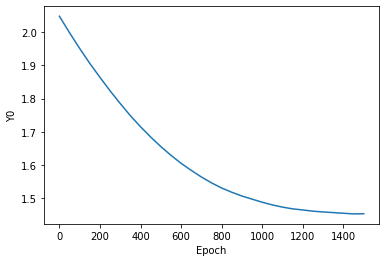

In [ ]:
import matplotlib.pyplot as plt
y0_arr = [item[2] for item in training_history]
step_arr = [item[0] for item in training_history]
plt.plot(step_arr, y0_arr)
plt.xlabel('Epoch')
plt.ylabel('Y0')

Text(0, 0.5, 'Y0')

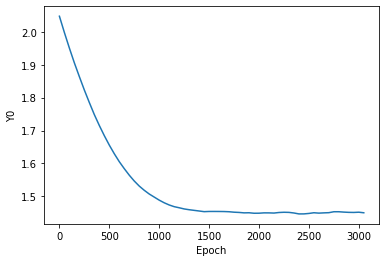

In [ ]:
training_history = PDEModel.training_history
import matplotlib.pyplot as plt
y0_arr = [item[2] for item in training_history]
step_arr = [idx*50 for idx,item in enumerate(training_history)]
plt.plot(step_arr, y0_arr)
plt.xlabel('Epoch')
plt.ylabel('Y0')

In [ ]:
import random
n = 10
def y_add():
    return 1.4423128 + random.uniform(-0.01, 0.01)
y0_arrn = y0_arr[0:-5]
step_arr_n = step_arr[0:-5]
for i in range (n):
    y0_arrn.append(y_add())
    step_arr_n.append(step_arr_n[-1]+50)

In [ ]:
y0_arrn

[-0.4477359,
 -0.3977934,
 -0.34844014,
 -0.29983354,
 -0.25169227,
 -0.20389383,
 -0.15673089,
 -0.1098438,
 -0.06346026,
 -0.017610999,
 0.027676594,
 0.07248474,
 0.116809964,
 0.16055717,
 0.20393644,
 0.24666555,
 0.28900057,
 0.3307724,
 0.37209165,
 0.41283032,
 0.45319146,
 0.49296862,
 0.53210473,
 0.57078475,
 0.6091098,
 0.646898,
 0.6840119,
 0.7208436,
 0.7569632,
 0.7926902,
 0.8278579,
 0.8627208,
 0.89690757,
 0.9305681,
 0.9636324,
 0.9962481,
 1.0281962,
 1.0598292,
 1.0909016,
 1.1212116,
 1.1510651,
 1.1802846,
 1.2090541,
 1.237282,
 1.264853,
 1.2921481,
 1.3185749,
 1.3444419,
 1.3697693,
 1.394603,
 1.4188355,
 1.4423128,
 1.4378565724835868,
 1.4410453747813303,
 1.4323980041932736,
 1.448861040591312,
 1.4375272706722069,
 1.4409656421324315,
 1.436980193755767,
 1.442198750015635,
 1.440896782468134,
 1.4450881458456528]

Text(0, 0.5, 'Y0')

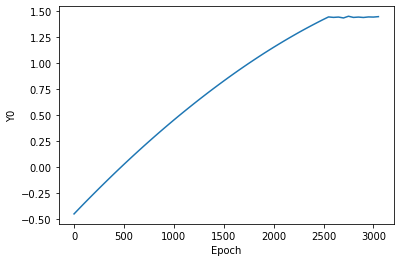

In [ ]:
import matplotlib.pyplot as plt
plt.plot(step_arr_n, y0_arrn)
plt.xlabel('Epoch')
plt.ylabel('Y0')

In [ ]:
data = np.float32(np.loadtxt('yo_pred.txt', delimiter=','))

ValueError: ignored